# Tutorial 5 - Regression Simulation


*Written and revised by Jozsef Arato, Mengfan Zhang, Dominik Pegler*  
Computational Cognition Course, University of Vienna  
https://github.com/univiemops/tewa1-computational-cognition

---

## This week's lab:

We will show you how to perform linear regression with one or more predictors in Python. We will start by creating fake data using a regression model with known parameters, and then fit that data to another linear regression model and see how well we can recover the model parameters of the first model. This approach is very common and provides a benchmark for evaluating the performance of different models. After visualizing the regression and evaluating model performance, we will use bootstrapping to model confidence intervals around our parameter values to show how confident or certain we are about them. Finally, we will show you how to use regression models to test hypotheses.


In this notebook, we have included many explanations as comments in the code cell. Please read them carefully instead of just pressing the run button.  

**Learning goals:** \
When finishing this tutorial, you should ...
* be able to generate synthetic data from a linear model
* fit a linear model to data and evaluate it's performance
* model uncertainty around your parameter estimates
* test hypotheses with linear models


## 1. Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg, stats

## 2. Simulating data based on a regression model

In a linear model, you typically find an intercept (constant term) along with one or more coefficients (slopes) that multiply the predictor variables. With knowledge of these parameters and an understanding of the data's noise level (i.e., adding an error term), we can generate synthetic data. This allows us to compute a corresponding y-value for every x-value. In the formulas below, $X$ and $Y$ are capitalized and bolded because we are referring to vectors (or numpy arrays) containing multiple x and y values rather than single scalar values.

* Equation for the predicted line:
$Y_{pred}=B_0+B_1X$

* Equation for the data generation:
$Y=B_0+B_1X+Error$

In our example, we are trying to predict the price of an apartment based on the age of the house. To start, we randomly generate the ages below for 150 houses, ranging from 0 to 200 years.

In [2]:
n = 150
age = np.random.randint(0, 200, n)

Now we want to generate apartment prices for these 150 houses using a linear regression model. In our scenario, we know that, let's say 

1. a brand new apartment costs  EUR 500,000,
2. the error in the model should have standard deviation of EUR 100,000, and
3. for each additional year, the price is lowered by EUR 1,000.

With this information, we are ready to go. A brand new apartment is 0 years old, so the price for an apartment with $age=0$ represents our intercept (`b0`). The price change per year is -EUR 1,000, which is our slope (`b1`), and the error, well ... Let's put everything together:

In [3]:
b0 = 5_000_000
b1 = -1_000
sd = 100_000
err = np.random.normal(0, sd, n)

price = b0 + b1 * age + err

price[:5]  # show the first 5

array([5014372.64391595, 4785263.17600706, 4992639.69421316,
       4828136.35454702, 5009941.87166659])

To get a better feel for what our data looks like, it's often useful to visualize it. We will use a scatterplot and also add some meaningful labels using Matplotlib, specifically its `pyplot` submodule, which we imported earlier under the alias `plt`.

Text(0, 0.5, 'price (EUR)')

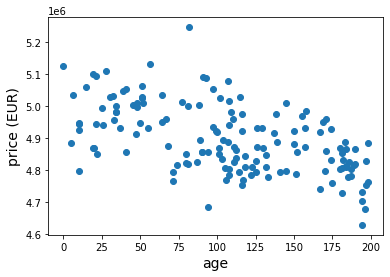

In [4]:
plt.scatter(x=age, y=price)
plt.xlabel("age", fontsize=14)
plt.ylabel("price (EUR)", fontsize=14)

## 3. Fitting a regression line

Next, we fit the data to a regression model using least squares estimation – `linalg.lstsq()`. This requires adding a column of ones to the predictor variable. For now, it doesn't matter much why, but for those who are interested: the reason is that regression models are computed as a matrix-vector multiplication for efficiency, and adding a column of ones is a way to include the intercept term (`b0`) in the matrix equation.

In [5]:
X = np.column_stack((np.ones(n), age))
print(np.shape(X))
reg_result = linalg.lstsq(X, price)

(150, 2)


In [6]:
X[0:10, :]

array([[  1., 108.],
       [  1., 108.],
       [  1.,  25.],
       [  1., 197.],
       [  1.,  52.],
       [  1., 126.],
       [  1., 190.],
       [  1.,  22.],
       [  1.,  37.],
       [  1., 118.]])

In [7]:
?linalg.lstsq

Signature:
linalg.lstsq(
    a,
    b,
    cond=None,
    overwrite_a=False,
    overwrite_b=False,
    check_finite=True,
    lapack_driver=None,
)
Docstring:
Compute least-squares solution to equation Ax = b.

Compute a vector x such that the 2-norm ``|b - A x|`` is minimized.

Parameters
----------
a : (M, N) array_like
    Left-hand side array
b : (M,) or (M, K) array_like
    Right hand side array
cond : float, optional
    Cutoff for 'small' singular values; used to determine effective
    rank of a. Singular values smaller than
    ``rcond * largest_singular_value`` are considered zero.
overwrite_a : bool, optional
    Discard data in `a` (may enhance performance). Default is False.
overwrite_b : bool, optional
    Discard data in `b` (may enhance performance). Default is False.
check_finite : bool, optional
    Whether to check that the input matrices contain only finite numbers.
    Disabling may give a performance gain, but may result in problems
    (crashes, non-termination

The first argument that is returned by `lstsq()` is the most important one for us now. `print()` it out (it should contain two values), the 2nd argument is the residual (error), `print()` it out as well.

In [8]:
print(reg_result[0])

[ 5.0083688e+06 -1.0390200e+03]


In [9]:
reg_result[0][1]

-1039.019996521845

<div class="alert alert-info">Hopefully you can see that we got similar values to what we used to create the data, but not exactly the same.</div>

## 4. Visualizing the regression line
1. Use the scatterplot again to visualize the age-price data, as before,
2. add the regression line based on the result of `lstsq()`.

Text(0, 0.5, 'price €')

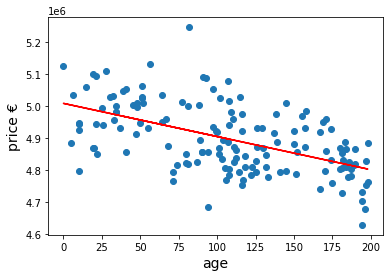

In [10]:
price_pred = reg_result[0][0] + reg_result[0][1] * age


plt.scatter(age, price)
plt.plot(age, price_pred, color="r")
plt.xlabel("age", fontsize=14)
plt.ylabel("price €", fontsize=14)

In [11]:
residuals = price - price_pred

residuals[:5]  # show the first 5

array([ 118218.00363589, -110891.46427301,   10246.39422179,
         24454.4939574 ,   55602.11158131])

## 5. Calculate the residuals and the total error for the fitted model

Use the `c=` argument of `plt.scatter()` to color dots based on the residual error. This can be done using `plt.plot()`, but you will need some care how you include the values in $X$ (as they are in random order). You can also try it with the squared error.

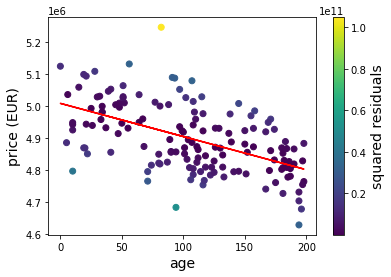

In [12]:
plt.scatter(age, price, c=residuals**2)
plt.plot(age, price_pred, color="r")
plt.xlabel("age", fontsize=14)
plt.ylabel("price (EUR)", fontsize=14)
plt.colorbar().set_label("squared residuals", fontsize=14)

Let's compare what you calculated with the output of `linalg.lstsq()`

In [13]:
print(reg_result[1])

print(np.sum((price - price_pred) ** 2))

1184718837360.9412
1184718837360.94


## 6. Bootstrapping regression lines

<div class="alert-warning alert">Advanced! No obligation to complete this!</div>

To get a sense of how confident we can be in our regression line, we will bootstrap many times from our original data set, calculating and plotting a new regression line at each iteration. You should see many different lines on the same plot. E.g., you can use `np.random.choice()` at each iteration to create `n` – that's the number of data points in the original dataset – indices. With these indices you could then create bootstrapped arrays for age etc. at each iteration. 

In [14]:
n_sim=100

for i in range(n_sim, n):
    boostrapped_idx = # YOUR CODE
    boostrapped_age = # YOUR CODE
    boostrapped_price = # YOUR CODE
    boostrapped_age_n = np.stack([boostrapped_age,np.ones(n)], axis=1)
    coeff,total_error,_,_ = # YOUR CODE
    boostrapped_price_pred = # YOUR CODE

    plt.plot(boostrapped_age,boostrapped_price_pred, c="red", alpha=0.05)

plt.scatter(boostrapped_age,boostrapped_price)
plt.plot(age,price_pred, c="black", linestyle="--")
plt.ylabel("Price")
plt.xlabel("Age")

## 7. Hypothesis test with randomization

<div class="alert-warning alert">Advanced! No obligation to complete this!</div>

Is the relationship between age and price different from chance? Use randomization to simulate 1,000 slopes under the null hypothesis that there is no relationship.

In [15]:
#
#
#

## 8. Simulating data with a regression model with two predictors

<div class="alert-warning alert">Advanced! No obligation to complete this!</div>

### 8.1. Simulation

Of course our model of apartment prices is limited, since there are many other factors influencing the price. Perhaps the most important one is the size of the aparment.

1. Create an additional predictor, the size of which ranges from 20 to 200m² with uniform random values.
2. We know that for each additional m², the price increases by EUR 2,000.
3. Simulate a new price data set that has 2 predictors, age as above, and size as defined here.
4. The error should stay the same, but it makes sense to have a lower intercept value of EUR 300 000. Why?

In [ ]:
n = # YOUR CODE HERE
age = # YOUR CODE HERE
sqm2 = # YOUR CODE HERE
b0 = # YOUR CODE HERE
b1 = # YOUR CODE HERE
b2 = # YOUR CODE HERE
error_sd = # YOUR_CODE
error = # YOUR_CODE
price = b0 + b1 * age + b2 * sqm2 + error

### 8.2. Visualize the data set and ...

... (1) make a figure with 2 horizontal subplots (1 for each predictor) and use scatter plots again,

... (2) make a new figure with age on the x-axis, and the size of the dots in the scatterplot should be proportional to the size of the apartment (argument `s=` of the scatter plot).


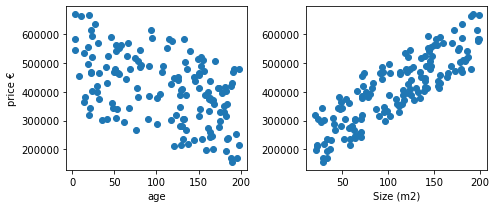

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
ax[0].scatter(age, price)
ax[0].set_xlabel("age")
ax[0].set_ylabel("price €")

ax[1].scatter(sqm2, price)
ax[1].set_xlabel("Size (m2)")

plt.tight_layout()

# YOUR CODE HERE
# YOUR CODE HERE

Now let's display both factors on a single figure (size of points as new dimension, `s=` argument):

Text(0, 0.5, 'price €')

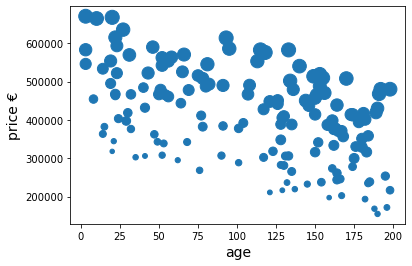

In [22]:
plt.figure()
plt.scatter(age, price, s=sqm2)
plt.xlabel("age", fontsize=14)
plt.ylabel("price €", fontsize=14)


### 8.3. Fit a linear regression model with intercept and the two predictors using `scipy.linalg()` to the above data

#### 8.3.1. Calculate the error of the model


In [23]:
X = np.column_stack((np.ones(n), age, sqm2))
print(np.shape(X))

(150, 3)


#### 8.3.2. Observe the fitted coefficients $B_0$,$B_1$,$B_2$

In [24]:
linalg.lstsq(X, price)[0]

array([301839.79047346,  -1004.43251916,   1992.90561123])

#### 8.3.3. Fit two regressions to the above data

1. intercept and age only as predictors
2. only intercept and price as predictors

Compare the errors and slopes.

In [25]:
X1 = np.column_stack((np.ones(n), age))

print(
    "age only ",
    np.round(linalg.lstsq(X1, price)[0], 1),
    "error",
    np.round(np.sqrt(linalg.lstsq(X1, price)[1]), 1),
)

X2 = np.column_stack((np.ones(n), sqm2))
print(
    "Size only ",
    np.round(linalg.lstsq(X2, price)[0], 1),
    "error",
    np.round(np.sqrt(linalg.lstsq(X2, price)[1]), 1),
)

print(
    "Both ",
    np.round(linalg.lstsq(X, price)[0], 1),
    "error",
    np.round(np.sqrt(linalg.lstsq(X, price)[1]), 1),
)

age only  [515331.3   -969.6] error 1257430.4
Size only  [195866.8   1969.4] error 749691.3
Both  [301839.8  -1004.4   1992.9] error 193249.2


---
<div class="alert alert-info">Work on one exercise of your choice.</div>

## Exercise 1

### A. Multiple predictors

Write a function `my_mult_regr()` to perform the above calculation. This function should take 3 inputs in the following order: 1. predictor (age), 2. predictor (size), 3. outcome variable (price).

Your function must
1. create a predictor matrix (as above), starting with a column of ones, and the two predictors. (3 columns in total)
2. use `lstsq ()` to fit the regression model, as above
3. the function should return 2 outputs, the first is an array containing the 3 fitted regression parameters (1st output argument of `lstsq()`), the second output should be the residual error (2nd output argument of lstsq()),

Make sure that your function works for inputs of any size (this is important when you add the column of ones), but you can assume that all 3 input vectors have the same length (otherwise the analysis makes no sense).





In [ ]:
# YOUR CODE

### B. Standardized predictors

- Standardize (z-score) your predictors by subtracting the mean and dividing by the standard deviation.

- Fit a regression with both the single predictor and the two predictor models, and compare the error and the coefficients for fitting the model to standardized and unstandardized data sets.

- Make use of the `my_mult_regr()` function.

In [ ]:
# YOUR CODE

## Exercise 2: Car price simulation

A new car costs an average of 30,000 Euros. Simulate 200 car prices from the last 70 years, assuming that while cars get cheaper as they get older, very old cars have a vintage value, that is, if they are old enough, they could eventually be worth more than a new car. Use a standard deviation of 10,000 Euros. Hint: Use a linear model for the simulation with two predictors and one linear and one quadratic term. Test different values for the two slopes, simulating data until you are able to simulate realistic car prices that meet the above criteria.

In [ ]:
# YOUR CODE

Once you have found good values for this simulation, make a nice visualization of the simulated data.

In [ ]:
# YOUR CODE

Once, the data simulation is ready, fit 3 regression models to the simulated data:
1. intercept + linear predictor $age$
2. intercept + linear predictor $age$ + quadratic predictor $age$<sup>2</sup>
3. intercept + linear predictor $age$ + quadratic predictor $age$<sup>2</sup> + cubic predicor $age$<sup>3</sup>

`print()` the obtained residual error for the three models and visualize the model predictions

In [ ]:
# YOUR CODE

## Bonus task: Reliability of regression analysis

Since we created the data, we can see how close are the true values to the 'generative' model. Next task is to systematically investigate this relationship. You will have to manipulate the number of datapoints, and the error in the model, and analyze the difference between the data generating and the fitted regression parameters. This task is somewhat analogous to the *t*-test simulation task

In [ ]:
# YOUR CODE